### Comparision of GNNs working with different input networks
This notebook compares the performance in graph classification using different graph datasets coming from different biological networks. 

In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, pickle, subprocess
from networks import bio_networks, utils
from create_datasets import create_nx_datasets, create_splits

**1. Obtain genes of interest**

Using DisGeNET to get Gene-Disease-Associations (GDAs) to Alzheimer's Disease (AD gene set) and other neurodegenerative diseases (ND).

In [ ]:
subprocess.call ("genes_of_interest/get_GDAs.R")

**2. Data preprocessing**

Please refer to `data_preprocessing` subdirectory for this part.
- 1. `make_BED_files.R` creates BED files with the genomic coordinates of the genes of interest
- 2. `extract_and_annotate_missense_dataset.sh` are scripts for obtaining missense variants from the VCF files.
- 3. `ADNIMERGE_processing.py` process ADNIMERGE table from ADNI dataset in order to obtain diagnostics information of each sample.

**3. Obtain biological networks**

Obtain new biological networks for the AD gene set from different sources:
1. STRING: Protein-Protein Interactions (PPIs)
2. BioGRID: Protein-Protein Interactions (PPIs)
3. Human Reference Interactome (HuRI): PPIs
4. PPT-Ohmnet dataset from Stanford Network Analysis Project (SNAP): brain-specific PPIs
5. GIANT: functional network, brain-specific

In [2]:
# STRING (PPI)
print('STRING')
edgelist_string = bio_networks.get_string('data/AD_GDAs.tsv')
print()

# BioGRID (PPI)
print('BioGRID')
edgelist_biogrid = bio_networks.get_biogrid('data/AD_GDAs.txt')
print()

# HuRI (PPI) - HuRI interactions were downloaded from HuRI webpage and then parsed to obtain the corresponding edgelist.
print('HuRI')
edgelist_huri = bio_networks.get_huri('data/other_networks/HuRI_download_interactions_dec_16_2021_11_54_03.csv')
print()

# PPT-Ohmnet (PPI, brain-specific)
print('PPT-Ohmnet')
network_snap = bio_networks.get_snap('data/AD_GDAs.txt')
print()

# GIANT (functional network, brain-specific)
print('GIANT')
network_giant = bio_networks.get_giant('data/AD_GDAs.txt')
print()

STRING
Unique genes from DisGeNET: 101
Whole network: 59 nodes
Biggest connected component: 52 nodes
Percentage of lost genes/nodes: 7 (11.86%)

BioGRID
Whole network: 46 nodes
Biggest connected component: 38 nodes
Percentage of lost genes/nodes: 8 (17.39%)

HuRI
Whole network: 18 nodes
Biggest connected component: 12 nodes
Percentage of lost genes/nodes: 6 (33.33%)

PPT-Ohmnet
querying 1-102...done.
Finished.
Whole network: 45 nodes
Biggest connected component: 29 nodes
Percentage of lost genes/nodes: 16 (35.56%)

GIANT
querying 1-102...done.
Finished.
Whole network: 45 nodes
Biggest connected component: 36 nodes
Percentage of lost genes/nodes: 9 (20.0%)



**4. Create graph datasets**

Create the correspoding graph-datasets for each newly obtained biological network.

In [3]:
dataset = 'ADNI'
targets = ['PET', 'PETandDX']
networks = ['string', 'biogrid', 'huri', 'snap_brain', 'giant_brain']

for target in targets:
    for network in networks:

        outdir = f'data/graph_datasets/{target}'

        result_nodes = create_nx_datasets.main('data', dataset, target, 'AD', network, 'missense', None)
        outfile = f'{outdir}/AD_PPI_{network}_missense.pkl'
        print('Resulting dataset saved at:', outfile)
        print()

        with open(outfile, 'wb') as f:
            pickle.dump(result_nodes, f)

data/AD_STRING_PPI_edgelist.txt
Network used: AD string
# nodes = 59
# edges = 115

Dataset used: ADNI
missense
(59, 808)
Creating samples graphs...
Class: PET. Found 410 positive subjects out of 726
Sample graph used: # nodes = 52 # edges = 111
Density = 0.083710407239819 Diameter = 6
Resulting dataset saved at: data/graph_datasets/PET/AD_PPI_string_missense.pkl

Network used: AD biogrid
# nodes = 46
# edges = 62

Dataset used: ADNI
missense
(46, 808)
Creating samples graphs...
Class: PET. Found 410 positive subjects out of 726
Sample graph used: # nodes = 38 # edges = 57
Density = 0.08108108108108109 Diameter = 5
Resulting dataset saved at: data/graph_datasets/PET/AD_PPI_biogrid_missense.pkl

Network used: AD huri
# nodes = 18
# edges = 16

Dataset used: ADNI
missense
(18, 808)
Creating samples graphs...
Class: PET. Found 410 positive subjects out of 726
Sample graph used: # nodes = 12 # edges = 13
Density = 0.19696969696969696 Diameter = 6
Resulting dataset saved at: data/graph_data

**5. Graph classification with GNNs**

We then evaluated and tested different GNNs in the framework called [GraphGym](https://github.com/snap-stanford/GraphGym) (You *et al.*, 2020).

Configuration and grid files employed are in the subdirectory [graphgym_files](graphgym_files).

Summarized results obtained by GraphGym and other models are in **COMPLETE**

We run GraphGym 10 times, with 10 different splits generated by 10-Fold Stratified Cross-Validation (see below).

In [ ]:
# Create splits for using it in GraphGym and non-GNN models
# Splits are obtained through 10-Fold Stratified Cross Validation

create_splits.create_folds_stratified_cv('PET', 10)
create_splits.create_folds_stratified_cv('PETandDX', 10)

#### 6. Analyze results
We obtained best GNN configurations in each split. Next, we selected the common configuration in all splits and obtained average and standard deviation over the 10 splits of several performance metrics (Accuracy, Precision, Recall, F1, AUC).

The following cells produce different Figures regarding performance metrics and compute their p-values trough a 1-sample t-test against the baseline model (Logistic Regression only with APOE gene as input). Please refer to **this notebook** COMPLETE! to see how to compute the baseline model.

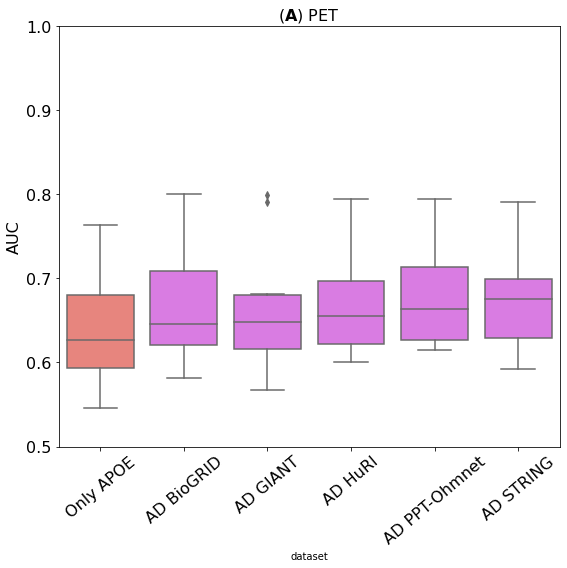

In [2]:
pet_GNN   = pd.read_csv('results/2022_03_networks_PET.csv', index_col='fold')
pet_bas   = pd.read_csv('results/2022_03_baseline_models_PET.csv',  index_col='fold')
pet_all   = pd.concat([pet_GNN, pet_bas])
pet_all.loc[pet_all["model"] == "Logistic Regression - Only APOE", "dataset"] = 'Only APOE'
pet_all.loc[pet_all["model"] == "Logistic Regression - Only APOE", "model"] = 'Logistic Regression'
utils.boxplot_comparision_others('PET', pet_all, 'auc', r"($\bf{A}$) PET")

In [11]:
pvalues_pet = utils.statistics(pet_results)
print(pvalues_pet)

df = pet_results.drop(columns =['fold', 'acc', 'pre', 'rec', 'f1'])
df['auc_mean'] = df.groupby(['dataset', 'model', 'target'])['auc'].transform('mean')
df['auc_std'] = df.groupby(['dataset', 'model'])['auc'].transform('std')
df = df.drop(columns=['auc'])
df.iloc[[0, 10, 20, 30, 40, 50]]

{'AD PPT-Ohmnet': 0.10071607071645536, 'AD STRING': 0.12241840380211852, 'AD HuRI': 0.17181326452204604, 'AD BioGRID': 0.21595301121112814, 'AD GIANT': 0.2485419526815798, 'Only APOE': 0.5}


,target,dataset,model,Unnamed: 9,auc_mean,auc_std
0,PET,Only APOE,Logistic Regression,"[[8, 24], [1, 40]]",0.640551,0.069063
10,PET,AD BioGRID,GNN GraphGym,NaN,0.664770,0.065611
20,PET,AD GIANT,GNN GraphGym,NaN,0.663490,0.078633
30,PET,AD HuRI,GNN GraphGym,NaN,0.669180,0.062402
40,PET,AD PPT-Ohmnet,GNN GraphGym,NaN,0.680130,0.064342
50,PET,AD STRING,GNN GraphGym,NaN,0.676260,0.063654


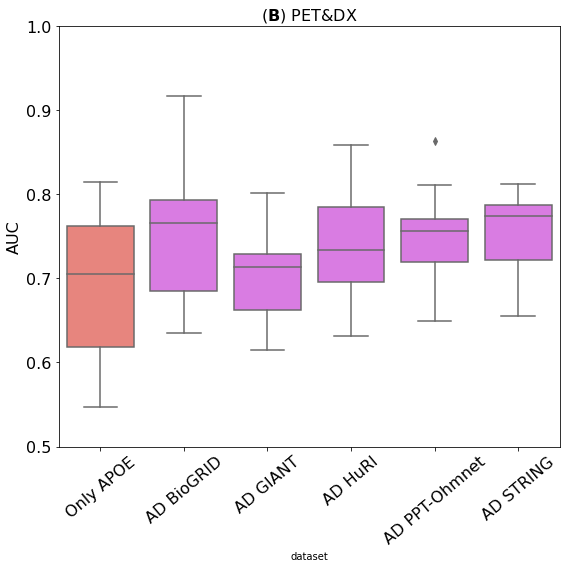

In [3]:
petdx_GNN   = pd.read_csv('results/2022_03_networks_PETandDX.csv', index_col='fold')
petdx_bas   = pd.read_csv('results/2022_03_baseline_models_PETandDX.csv',  index_col='fold')
petdx_all   = pd.concat([petdx_GNN, petdx_bas])
petdx_all.loc[petdx_all["model"] == "Logistic Regression - Only APOE", "dataset"] = 'Only APOE'
petdx_all.loc[petdx_all["model"] == "Logistic Regression - Only APOE", "model"] = 'Logistic Regression'
utils.boxplot_comparision_others('PETandDX', petdx_all, 'auc', r"($\bf{B}$) PET&DX")

In [9]:
pvalues_petdx = utils.statistics(petdx_results)
print(pvalues_petdx)

df = petdx_results.drop(columns =['fold', 'acc', 'pre', 'rec', 'f1'])
df['auc_mean'] = df.groupby(['dataset', 'model', 'target'])['auc'].transform('mean')
df['auc_std'] = df.groupby(['dataset', 'model'])['auc'].transform('std')
df = df.drop(columns=['auc'])
df.iloc[[0, 10, 20, 30, 40, 50]]

{'AD PPT-Ohmnet': 0.051717255609973756, 'AD STRING': 0.05469058028620656, 'AD BioGRID': 0.06926328684824597, 'AD HuRI': 0.10254157203420601, 'AD GIANT': 0.3604574252913516, 'Only APOE': 0.5}


,target,dataset,model,auc_mean,auc_std
0,PETandDX,Only APOE,Logistic Regression,0.690087,0.097874
10,PET&DX,AD BioGRID,GNN GraphGym,0.752640,0.081888
20,PET&DX,AD GIANT,GNN GraphGym,0.703470,0.063408
30,PET&DX,AD HuRI,GNN GraphGym,0.739690,0.068216
40,PET&DX,AD PPT-Ohmnet,GNN GraphGym,0.752060,0.058927
50,PET&DX,AD STRING,GNN GraphGym,0.750230,0.056311
